# Modelling poisson using PINN

Solving the poisson equation $-\Delta u = f$ using a physics informed neural network 

## 1D problem

### Manufactured solution


We use $u = sin(2*x)$ for $x\in [0,4]$ to manufacture the right hand side to be $f=sin(x)$

### Importing packages

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [78]:
np.random.seed(123)
X_tr_pde = np.random.uniform(0,2*np.pi,1000).reshape(1000,1)


#### Plotting histogram of randomly selected points to make sure they are uniformly distributed 

Text(0, 0.5, 'frequency ')

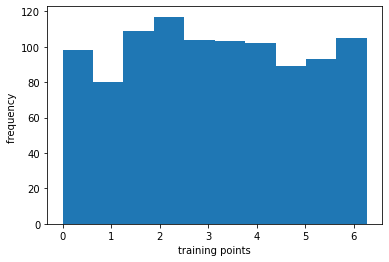

In [79]:
plt.hist(X_tr_pde)
plt.xlabel("training points")
plt.ylabel("frequency ")

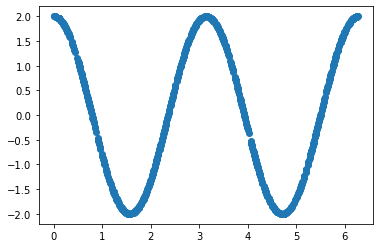

In [80]:
Y_tr_pde = 2*np.cos(2*X_tr_pde)
plt.scatter(X_tr_pde,Y_tr_pde)

In [81]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((X_tr_pde.size,1))],axis=1)
Y_tr_pde.shape

(1000, 2)

In [82]:
X_tr_Dr_bc_left = np.zeros(100).reshape(100,1)
X_tr_Dr_bc_right = 2*np.pi*np.ones(100).reshape(100,1)
X_bc = np.concatenate([X_tr_Dr_bc_left,X_tr_Dr_bc_right],axis=0)

Y_tr_Dr_bc_left = np.sin(X_tr_Dr_bc_left)
Y_tr_Dr_bc_right = np.sin(X_tr_Dr_bc_right)
Y_tr_bc = np.concatenate([Y_tr_Dr_bc_left,Y_tr_Dr_bc_right],axis=0)
Y_tr_bc = np.concatenate([Y_tr_bc,np.ones((200,1))],axis=1)
Y_tr_bc

array([[ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.0000000e+00,  1.0000000e+00],
       [ 0.00000

In [83]:
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_tr_bc), axis=0)

In [84]:
Y_tr

array([[-1.56429919e+00,  0.00000000e+00],
       [-1.79727702e+00,  0.00000000e+00],
       [-1.91597615e+00,  0.00000000e+00],
       ...,
       [-2.44929360e-16,  1.00000000e+00],
       [-2.44929360e-16,  1.00000000e+00],
       [-2.44929360e-16,  1.00000000e+00]])

## Training the model

In [85]:
from tensorflow.keras import backend as K
class CustomModel(tf.keras.Model):

    def __init__(self):
        super(CustomModel, self).__init__()
        self.dense_1 = keras.layers.Dense(30, activation="elu",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(30, activation="elu",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(1,
                                         name="dense_3")

    def findGrad(self,func,argm):
        return keras.layers.Lambda(lambda x: K.gradients(x[0],x[1])) ([func,argm])
    
    def call(self, inputs):
        layer_1 = self.dense_1(inputs)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        
        grad_layer = self.findGrad(layer_3, inputs)
#         laplace_layer = self.findGrad(grad_layer, inputs)
        
        return layer_3, grad_layer



In [86]:
custom_model = CustomModel()

In [87]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_true_act-y_pred)
    return tf.where(at_boundary,0.,pde_sq_error)

In [88]:
custom_model.compile(loss=[u_loss,pde_loss],optimizer=keras.optimizers.SGD(lr=1e-2))

In [89]:
custom_model.fit(x=X_tr, y=Y_tr,epochs=50)

Epoch 1/50
38/38 [==============================] - 0s 5ms/step - loss: 0.8577 - output_1_loss: 0.0044 - output_2_1_loss: 0.8533
Epoch 2/50
38/38 [==============================] - 0s 4ms/step - loss: 0.8486 - output_1_loss: 4.3678e-04 - output_2_1_loss: 0.8482
Epoch 3/50
38/38 [==============================] - 0s 5ms/step - loss: 0.8445 - output_1_loss: 2.1364e-04 - output_2_1_loss: 0.8443
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.8415 - output_1_loss: 7.0549e-04 - output_2_1_loss: 0.8408
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 0.8384 - output_1_loss: 2.6630e-04 - output_2_1_loss: 0.8381
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 0.8358 - output_1_loss: 5.9418e-04 - output_2_1_loss: 0.8352
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 0.8338 - output_1_loss: 3.6786e-04 - output_2_1_loss: 0.8334
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - loss: 0

In [96]:
custom_model.compile(loss=[u_loss,pde_loss],optimizer=keras.optimizers.SGD(lr=1e-2))
custom_model.fit(x=X_tr, y=Y_tr,epochs=50)

Epoch 1/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0186 - output_1_loss: 1.7516e-04 - output_2_1_loss: 0.0185
Epoch 2/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0181 - output_1_loss: 2.1130e-04 - output_2_1_loss: 0.0179
Epoch 3/50
38/38 [==============================] - 0s 3ms/step - loss: 0.0186 - output_1_loss: 2.7656e-04 - output_2_1_loss: 0.0183
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0187 - output_1_loss: 1.7601e-04 - output_2_1_loss: 0.0186
Epoch 5/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0189 - output_1_loss: 1.4803e-04 - output_2_1_loss: 0.0188
Epoch 6/50
38/38 [==============================] - 0s 4ms/step - loss: 0.0183 - output_1_loss: 2.2282e-04 - output_2_1_loss: 0.0180
Epoch 7/50
38/38 [==============================] - 0s 5ms/step - loss: 0.0184 - output_1_loss: 1.7615e-04 - output_2_1_loss: 0.0183
Epoch 8/50
38/38 [==============================] - 0s 5ms/step - los

In [97]:
X_test_st = np.random.uniform(0,2*np.pi,500).reshape(500,1)

In [98]:
Y_test = custom_model.predict(X_test_st)

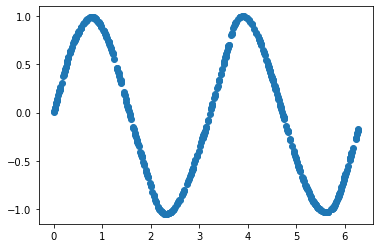

In [99]:
plt.scatter(X_test_st, Y_test[0][:,0])

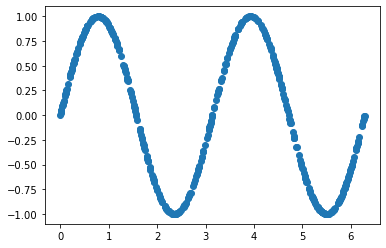

In [100]:
plt.scatter(X_test_st,np.sin(2*X_test_st))